<a href="https://colab.research.google.com/github/GabrielChuchuca/SIMULACION/blob/main/Deber3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#pip install simpy
#pip install pygal

     |████████████████████████████████| 127 kB 28.4 MB/s 


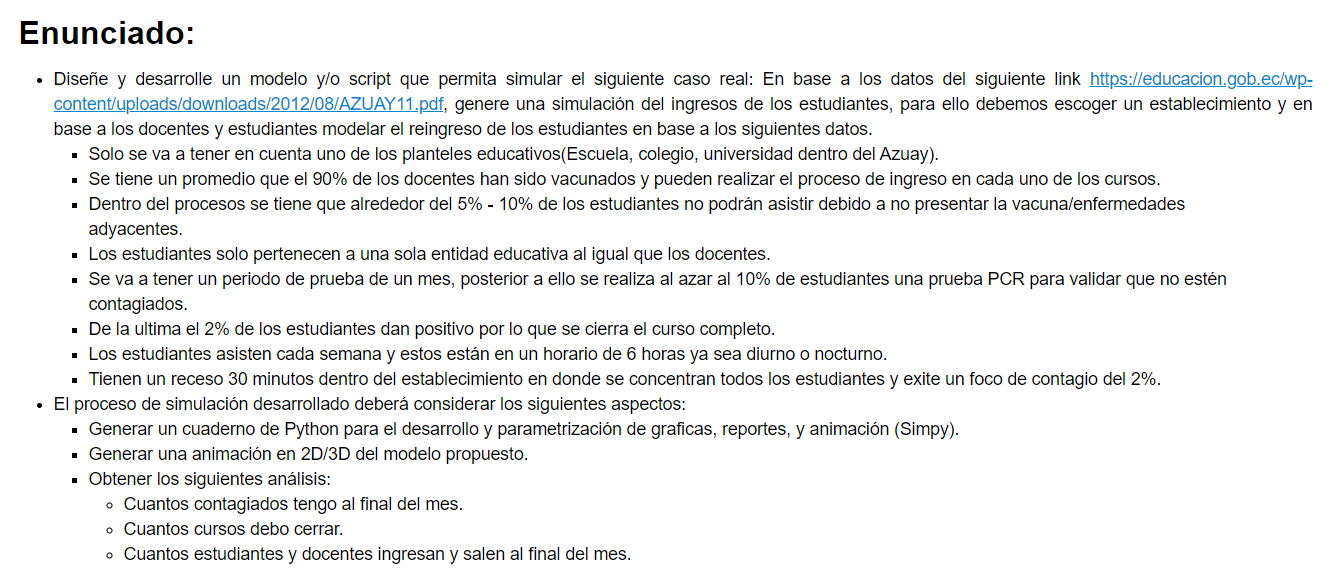

In [8]:
#Importación de librerías
import matplotlib.pyplot as plt
import simpy
import random as rand
import datetime 
from statistics import mean
import math

#Nueva libreria para graficas
import seaborn as sns
import pygal

%matplotlib inline

In [9]:
# Total docentes = 11
DOCENTES = 11

# Total estudiantes = 147
ESTUDIANTES = 147

#Personal a cargo de la prueba PCR
PERSONAL_PCR = 5

# Total de cursos = numEstudiantes / numDocentes
CURSOS = math.ceil(ESTUDIANTES/DOCENTES)

# Se tiene un promedio que el 90% de los docentes han sido vacunados
TOTAL_DOCENTES = int(DOCENTES*0.9)

#Dentro del procesos se tiene que alrededor del 5% - 10% de los estudiantes no podrán asistir debido a no presentar la vacuna/enfermedades.
TOTAL_ESTUDIANTES = int(ESTUDIANTES*0.8)

#Total de estudiantes contagiados en el receso
TOTAL_ESTUDIANTES_CONTAGIADOS = 0

#Periodo de prueba = 1 mes ** Se multiplica las horas de clase por 60 para obtener el total de minutos al dia 
PERIODO_PRUEBA = 30 #dias
TIEMPO_POR_DIA = (6*60)

# Tiempo Prueba PCR
TIEMPO_TOTAL_PRUEBA_PCR = 0

# Tiempo de prueba PCR de cada persona
TIEMPO_PRUEBA_PER_PERS = {}

# Distribución de estudiante por curso
ESTUDIANTE_PER_CURSO = {}

#Tienen un receso 30 minutos dentro del establecimiento 
RECESO_POR_DIA = 30

#Estudiantes PCR.
PRUEBA_PCR = 0

#Estudiantes contagiados
ESTUDIANTES_CONTAGIADOS = 0

#Estudiantes que no entrar a clases por vacuna o enfermedades
ESTUDIANTES_NO_CLASES = 0

TOTAL_PERSONAS = 0

#Cuantos estudiantes ingresan y salen al final del mes.
TOTAL_ESTUDIANTES_FIN_MES = 0

#Cuantos docentes ingresan y salen al final del mes.
TOTAL_DOCENTES_FIN_MES = 0

TIEMPO_SIMULACION = 40000


#Division de horas para los dos periodos de clases teniendo en cuenta que hay 1 recreo de 30 min
periodo1 = int(round(TIEMPO_POR_DIA-RECESO_POR_DIA)/2)
periodo2 = int(round(TIEMPO_POR_DIA-RECESO_POR_DIA)/2)

ESTUDIANTES_BILINGUE = {}

NO_CUMPLE = []
CONTAGIADOS_RECREO = []
ESTUDIANTES_CONTAGIADOS_RECREO = []

ESTUDIANTE_PRUEBA_10 = []


PRUEBA_PCR= []

PRUEBA_PCR_RESULTADO = []

prueba_pcr_preseleccion={}

In [10]:
for i in range(TOTAL_ESTUDIANTES):
    ESTUDIANTES_BILINGUE[i]="NO",i

In [11]:
for i in range(TOTAL_ESTUDIANTES):
    ESTUDIANTE_PER_CURSO[i] = i, rand.randint(1,CURSOS)

In [12]:
def regresoClases(env, name, clases, **duration):
    rnd = rand.randint(1,ESTUDIANTES)
    no_entra_clases = 0
    si_entra_clases_uid = []
    if rnd <= 8:
        no_entra_clases+=1
        NO_CUMPLE.append(int(no_entra_clases))
        print(f'{name} No puede entrar a clases, ENFERMO/SIN VACUNA {round(env.now, 2)}')
        
    else:
        with clases.request() as req:
            yield req 
            #1: Entra a clases
            print(f'{name} Entra a clases a las {round(env.now)}')
            yield env.timeout(duration['entra_clases'])
            
            #2: Sale al recreo
            print(f'{name} Sale al recreo a las {round(env.now)}')
            yield env.timeout(duration['sale_recreo'])
            
            for i in range(len(ESTUDIANTES_BILINGUE)):
                contagio_recreo = 0
#                 aux = []
                
                rnd_recreo = rand.randint(1,len(ESTUDIANTES_BILINGUE))            
                if rnd_recreo < math.ceil(len(ESTUDIANTES_BILINGUE)*0.02):
                    
                    estudiante = ESTUDIANTES_BILINGUE[i][1]
            
                    contagio_recreo+=1

                    ESTUDIANTES_CONTAGIADOS_RECREO.append(estudiante)
                    CONTAGIADOS_RECREO.append(int(contagio_recreo))
                    
            #3: Regresa a clases
            print(f'{name} Regresa a clases a las {round(env.now)}')
            yield env.timeout(duration['regresa_clases'])

            #4: Entra a clases
            print(f'{name} Se va a la casa a las {round(env.now)}')
            yield env.timeout(duration['sale_casa'])
   
        #---------------PRUEBA PCR----------------#
        yield env.timeout(duration['pruebaPCR'])
        
        rnd_PCR = rand.randint(1,100)
        pruebaPCR = 0
        if rnd_PCR <= math.ceil(len(ESTUDIANTES_BILINGUE)*0.10):
            print(f'{name} para prueba PCR {round(env.now, 2)}')
            pruebaPCR=+1
            PRUEBA_PCR.append(int(pruebaPCR))
            print('Hasta aqui')
        
            rnd_PCR_SI = rand.randint(1,len(ESTUDIANTES_BILINGUE))
            rnd_resultado_pcr = 0
           
            if rnd_PCR_SI <= math.ceil(len(ESTUDIANTES_BILINGUE)*0.02):
                print('Hasta 1')
                print(f'{name} RESULTADO ** CONTAGIADO {round(env.now, 2)}')
                
                rnd_resultado_pcr=+1
                PRUEBA_PCR_RESULTADO.append(int(rnd_resultado_pcr))

In [13]:
env = simpy.Environment()

# Model restaurant that can only allow 2 customers at once
clases = simpy.Resource(env, capacity=TOTAL_ESTUDIANTES)
durations = {'entra_clases': periodo1, 'sale_recreo': RECESO_POR_DIA, 'regresa_clases': periodo2, 'sale_casa': 2, 'pruebaPCR':30}

#CONTAGIOS POR PRUEBA PCR
a = len(PRUEBA_PCR_RESULTADO)
if a == 0:
    print('NO HUBIERON CONTAGIADOS :) ')
else:
    print('Si hay contagiados,total',PRUEBA_PCR_RESULTADO)
    
#cursos = {}
for i in range(TOTAL_ESTUDIANTES):
    env.process(regresoClases(env, f'Estudiante {i}', clases, **durations))
env.run(until=TIEMPO_SIMULACION)

NO HUBIERON CONTAGIADOS :) 
Estudiante 33 No puede entrar a clases, ENFERMO/SIN VACUNA 0
Estudiante 83 No puede entrar a clases, ENFERMO/SIN VACUNA 0
Estudiante 106 No puede entrar a clases, ENFERMO/SIN VACUNA 0
Estudiante 0 Entra a clases a las 0
Estudiante 1 Entra a clases a las 0
Estudiante 2 Entra a clases a las 0
Estudiante 3 Entra a clases a las 0
Estudiante 4 Entra a clases a las 0
Estudiante 5 Entra a clases a las 0
Estudiante 6 Entra a clases a las 0
Estudiante 7 Entra a clases a las 0
Estudiante 8 Entra a clases a las 0
Estudiante 9 Entra a clases a las 0
Estudiante 10 Entra a clases a las 0
Estudiante 11 Entra a clases a las 0
Estudiante 12 Entra a clases a las 0
Estudiante 13 Entra a clases a las 0
Estudiante 14 Entra a clases a las 0
Estudiante 15 Entra a clases a las 0
Estudiante 16 Entra a clases a las 0
Estudiante 17 Entra a clases a las 0
Estudiante 18 Entra a clases a las 0
Estudiante 19 Entra a clases a las 0
Estudiante 20 Entra a clases a las 0
Estudiante 21 Entra a

In [14]:
mylist = list(set(ESTUDIANTES_CONTAGIADOS_RECREO))

In [15]:
print('Total de estudiantes:',ESTUDIANTES)
print('Total de estudiantes que ingresaron a clases:',TOTAL_ESTUDIANTES)
print('Total de estudiantes que no ingresaron a clases:',ESTUDIANTES-TOTAL_ESTUDIANTES)
print('Total de estudiantes que se contagiaron en el recreo:',len(mylist))
print('Personas que salieron positivo en las pruebas PCR:', len(PRUEBA_PCR_RESULTADO))
print('Se deben cerrar', len(PRUEBA_PCR_RESULTADO))

Total de estudiantes: 147
Total de estudiantes que ingresaron a clases: 117
Total de estudiantes que no ingresaron a clases: 30
Total de estudiantes que se contagiaron en el recreo: 103
Personas que salieron positivo en las pruebas PCR: 0
Se deben cerrar 0
